In [5]:
!git clone https://github.com/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation.git
!pip install -q -r /content/Hybrid_Transformer_for_Portfolio_Allocation/requirements.txt

fatal: destination path 'Hybrid_Transformer_for_Portfolio_Allocation' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 5.8 MB/s eta 0:00:00


In [2]:
from Hybrid_Transformer_for_Portfolio_Allocation.data.eq_data_loader import get_eq_data
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_hybrid import hybrid_transformer_database
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_vanilla import vanilla_transformer_database
from Hybrid_Transformer_for_Portfolio_Allocation.models.hybrid_transformer_model import HybridTransformer_Portfolio

import pandas as pd
import numpy as np
import tensorflow as tf
import json

In [3]:
data_config = json.load(open('/content/Hybrid_Transformer_for_Portfolio_Allocation/configs/data_config.json', 'r'))

In [4]:
data = get_eq_data(
    '/content/Hybrid_Transformer_for_Portfolio_Allocation/data/nifty_50_metadata.csv',
    start = data_config['data_start_date'],
    end = data_config['data_end_date'],
    corr_thresh = data_config['correlation_thresh'],
    market_cap_filter = data_config['market_cap_filter']
)

[*********************100%%**********************]  50 of 50 completed


In [5]:
xtrain, xtest, ytrain, ytest, train_index, test_index = hybrid_transformer_database(data = data, timestep = 32, lag = 3, lagSD = 3, test_size= 0.2, purge_size = 30)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(1962, 32, 34) (499, 32, 34) (1962, 17) (499, 17)


In [6]:
tf.keras.backend.clear_session()

In [7]:
from sklearn.model_selection import train_test_split
attention_numbers = [4, 8, 16, 32]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [4, 8, 16]
dropouts = [0.05, 0.1]

trainx, valx, trainy, valy = train_test_split(xtrain.numpy(), ytrain.numpy(), test_size = 0.2, shuffle = False)

model_performance = pd.DataFrame()

for an in attention_numbers:
    for lr in learning_rates:
        for bs in batch_sizes:
            for dp in dropouts:
                trainx = tf.convert_to_tensor(trainx[:int(trainx.shape[0] / bs) * bs, :, :], np.float32)
                trainy = tf.convert_to_tensor(trainy[:trainx.shape[0], :], np.float32)
                val_price = tf.convert_to_tensor(data.loc[train_index, :].iloc[:trainx.shape[0], :].values, np.float32)

                model = HybridTransformer_Portfolio(trainx.shape[1], trainx.shape[2], outputShape = trainy.shape[1],  headsAttention = an, dropout= dp, learningRate = lr, priceData = val_price, lb= 0, ub = 0.3)
                model.allocation_hybrid_train(trainx, trainy, Epochs = 10, BatchSize = bs)

                eval_price = data.iloc[-valx.shape[0]:, :]
                eval_weights = model.allocation_hybrid_test(valx)
                eval_mean = (eval_price.pct_change().dropna() * eval_weights[1:, :]).sum(axis = 1).mean()
                eval_std = (eval_price.pct_change().dropna() * eval_weights[1:, :]).sum(axis = 1).std()
                eval_sharpe = eval_mean / eval_std

                tf.keras.backend.clear_session()

                temp_performance = pd.DataFrame()
                temp_performance['attention_num'] = [an]
                temp_performance['learning_rate'] = [lr]
                temp_performance['batch_size'] = [bs]
                temp_performance['dropout'] = [dp]
                temp_performance['eval_sharpe_ratio'] = [eval_sharpe]

                model_performance = pd.concat([model_performance, temp_performance])

13/13 [==============================] - 1s 13ms/step


In [8]:
model_performance.sort_values('eval_sharpe_ratio', ascending = False)

,attention_num,learning_rate,batch_size,dropout,eval_sharpe_ratio
0,4,0.0100,4,0.05,0.192038
0,4,0.0010,16,0.05,0.189281
0,4,0.0100,8,0.05,0.188342
0,16,0.0001,8,0.05,0.188104
0,8,0.0001,16,0.05,0.187211
...,...,...,...,...,...
0,32,0.0010,8,0.10,0.153273
0,8,0.0010,16,0.05,0.152100
0,8,0.0010,8,0.05,0.151978
0,32,0.0010,4,0.05,0.146096


In [6]:
tf.keras.backend.clear_session()

In [7]:
Dropout = 0.05
LearningRate = 0.01
Epochs = 10
Alpha = 0.005
DF = 4
BatchSize = 4
lb = 0
ub = 0.3
num_heads = 4

xtrain = xtrain[:int(xtrain.shape[0] / BatchSize) * BatchSize, :, :]
ytrain = ytrain[:xtrain.shape[0], :]
priceData = tf.convert_to_tensor(data.loc[train_index, :].iloc[:xtrain.shape[0], :].values, np.float32)

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

hybrid_model = HybridTransformer_Portfolio(xtrain.shape[1], xtrain.shape[2], outputShape = ytrain.shape[1],  headsAttention = num_heads, dropout= Dropout, learningRate = LearningRate, priceData = priceData, lb= lb, ub = ub)
hybrid_model.allocation_hybrid_train(xtrain, ytrain, Epochs = Epochs, BatchSize = BatchSize)

In [8]:
test_weights = hybrid_model.allocation_hybrid_test(xtest)

16/16 [==============================] - 1s 9ms/step


In [9]:
test_weights

array([[0.01778034, 0.03919996, 0.04444251, ..., 0.04420168, 0.10791425,
        0.06903537],
       [0.01813644, 0.0385952 , 0.04473542, ..., 0.04357507, 0.10739691,
        0.06855536],
       [0.01875618, 0.03855214, 0.04516062, ..., 0.04280343, 0.1081824 ,
        0.06817832],
       ...,
       [0.029985  , 0.0367759 , 0.04767324, ..., 0.03776914, 0.11862109,
        0.05970428],
       [0.02947435, 0.03663736, 0.04687965, ..., 0.03787468, 0.11914564,
        0.06042778],
       [0.02922636, 0.03648017, 0.04676994, ..., 0.03765494, 0.11942391,
        0.06044653]], dtype=float32)

In [10]:
test_mean = ((data.loc[test_index, :].pct_change().dropna() * test_weights[:-1, :]).sum(axis = 1) ).mean()
test_mean

0.0011281172958912417

In [11]:
test_std = ((data.loc[test_index, :].pct_change().dropna() * test_weights[:-1, :]).sum(axis = 1)).std()
test_std

0.007365647187174684

In [12]:
test_mean / test_std

0.15315929031403486

In [13]:
eq_w_mean = (data.loc[test_index, :] * np.ones(test_weights.shape) * 10000 / 17).sum(axis = 1).pct_change().dropna().mean()
eq_w_std = (data.loc[test_index, :] * np.ones(test_weights.shape) * 10000 / 17).sum(axis = 1).pct_change().dropna().std()

In [14]:
eq_w_mean / eq_w_std

0.09016788806911168

In [15]:
test_mean, eq_w_mean

(0.0011281172958912417, 0.0007130024391044412)

In [16]:
test_std, eq_w_std

(0.007365647187174684, 0.007907498493897746)

In [17]:
from runtime_test.data_prep_vanilla import vanilla_transformer_database
from runtime_test.benchmark_transformer_model import Transformer_Portfolio

xtrain1, xtest1, ytrain1, ytest1, train_index1, test_index1 = vanilla_transformer_database(data = data, timestep = 32, lag = 3, lagSD = 3, test_size= 0.2, purge_size = 30)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(1960, 32, 34) (499, 32, 34) (1960, 17) (499, 17)


In [18]:
Dropout = 0.05
LearningRate = 0.0001
Epochs = 10
Alpha = 0.005
DF = 4
BatchSize = 4
lb = 0
ub = 0.3
num_heads = 34

xtrain1 = xtrain1[:int(xtrain1.shape[0] / BatchSize) * BatchSize, :, :]
ytrain1 = ytrain1[:xtrain1.shape[0], :]
priceData1 = tf.convert_to_tensor(data.loc[train_index1, :].iloc[:xtrain1.shape[0], :].values, np.float32)

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

vanilla_model = Transformer_Portfolio(xtrain1.shape[1], xtrain1.shape[2], outputShape = ytrain1.shape[1],  headsAttention = num_heads, dropout= Dropout, learningRate = LearningRate, priceData = priceData1, lb= lb, ub = ub)
vanilla_model.allocation_vanilla_train(xtrain1, ytrain1, Epochs = Epochs, BatchSize = BatchSize)

62/62 [==============================] - 1s 10ms/step


array([[0.01549738, 0.0837767 , 0.07262972, ..., 0.05466919, 0.03796842,
        0.04789825],
       [0.0154734 , 0.0844568 , 0.07120663, ..., 0.05538334, 0.0378249 ,
        0.04814485],
       [0.01522209, 0.08495694, 0.07069644, ..., 0.05578868, 0.03757392,
        0.04860327],
       ...,
       [0.0129214 , 0.09229568, 0.05751938, ..., 0.05090897, 0.03885549,
        0.06154787],
       [0.01301186, 0.09107408, 0.05836646, ..., 0.05084955, 0.03901109,
        0.06184683],
       [0.01298643, 0.09177118, 0.05956586, ..., 0.05076297, 0.03891824,
        0.06115242]], dtype=float32)

In [19]:
test_weights1 = vanilla_model.allocation_vanilla_test(xtest1)

16/16 [==============================] - 0s 10ms/step


In [20]:
test_mean1 = ((data.loc[test_index1, :].pct_change().dropna() * test_weights1[:-1, :]).sum(axis = 1) - 0.01 * (test_weights1[1:, :] - test_weights1[:-1, :]).sum(axis = 1)).mean()

In [21]:

test_std1 = ((data.loc[test_index1, :].pct_change().dropna() * test_weights1[:-1, :]).sum(axis = 1) - 0.01 * (test_weights1[1:, :] - test_weights1[:-1, :]).sum(axis = 1)).std()

In [22]:
tf.keras.backend.clear_session()

In [23]:
test_mean1 / test_std1

0.14867097239329075

In [24]:
test_mean, test_mean1, eq_w_mean

(0.0011281172958912417, 0.0010445065578596085, 0.0007130024391044412)

In [25]:

test_std, test_std1, eq_w_std

(0.007365647187174684, 0.007025625386349765, 0.007907498493897746)

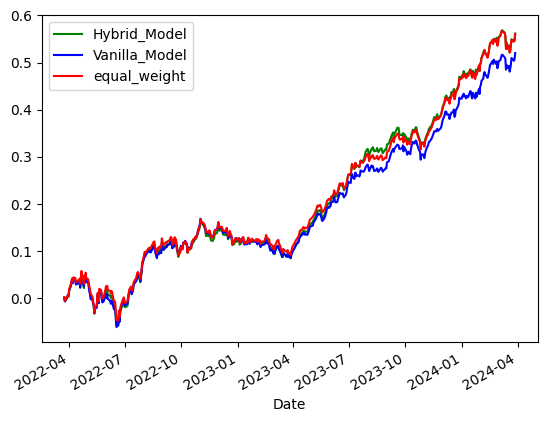

In [38]:
import matplotlib.pyplot as plt

((data.loc[test_index, :].pct_change().dropna() * test_weights[:-1, :]).sum(axis = 1)- 0.01 * (test_weights[1:, :] - test_weights[:-1, :]).sum(axis = 1)).cumsum().plot(color = 'green')
((data.loc[test_index, :].pct_change().dropna() * test_weights1[:-1, :]).sum(axis = 1)- 0.01 * (test_weights[1:, :] - test_weights[:-1, :]).sum(axis = 1)).cumsum().plot(color = 'blue')
(data.loc[test_index, :].pct_change().dropna() * np.ones(test_weights[:-1, :].shape) * 1 / 17).sum(axis = 1).cumsum().plot(color = 'red',)
plt.legend(['Hybrid_Model','Vanilla_Model', 'equal_weight'])
plt.show()

In [27]:
((data.loc[test_index, :].pct_change().dropna() * test_weights[:-1, :]).sum(axis = 1) - 0.01 * (test_weights[1:, :] - test_weights[:-1, :]).sum(axis = 1)).cumsum()

Date
2022-03-24    0.001620
2022-03-25   -0.006486
2022-03-28   -0.001558
2022-03-29    0.002547
2022-03-30    0.003292
                ...   
2024-03-21    0.537928
2024-03-22    0.549633
2024-03-26    0.545291
2024-03-27    0.547510
2024-03-28    0.561802
Length: 498, dtype: float64

In [28]:
(data.loc[test_index, :].pct_change().dropna() * np.ones(test_weights[:-1, :].shape) * 1 / 17).sum(axis = 1).cumsum()

Date
2022-03-24    0.002138
2022-03-25   -0.005193
2022-03-28    0.001200
2022-03-29    0.003683
2022-03-30    0.005916
                ...   
2024-03-21    0.537438
2024-03-22    0.548167
2024-03-26    0.544244
2024-03-27    0.547390
2024-03-28    0.560355
Length: 498, dtype: float64

In [29]:
((data.loc[test_index, :].pct_change().dropna() * test_weights1[1:, :]).sum(axis = 1) - 0.01 * (test_weights1[1:, :] - test_weights1[:-1, :]).sum(axis = 1)).cumsum()

Date
2022-03-24    0.001144
2022-03-25   -0.006503
2022-03-28    0.000460
2022-03-29    0.004756
2022-03-30    0.006728
                ...   
2024-03-21    0.494482
2024-03-22    0.508394
2024-03-26    0.502513
2024-03-27    0.506590
2024-03-28    0.518734
Length: 498, dtype: float64

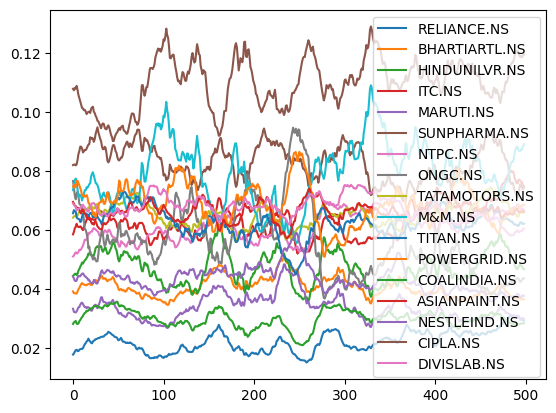

In [30]:
plt.plot(test_weights)
plt.legend(data.columns)

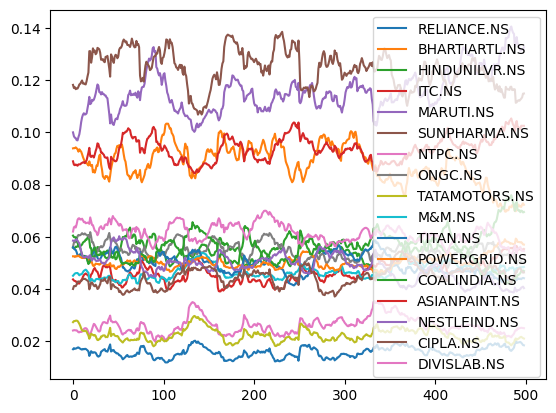

In [31]:
plt.plot(test_weights1)
plt.legend(data.columns)

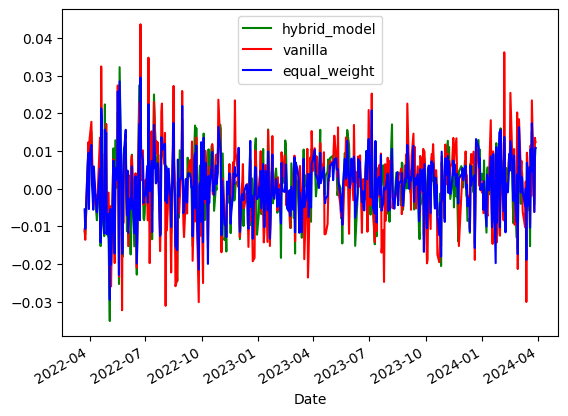

In [32]:
import matplotlib.pyplot as plt
(data.loc[test_index, :] * test_weights * 10000).sum(axis = 1).pct_change().dropna().plot(color = 'green')

(data.loc[test_index1, :] * test_weights1 * 10000).sum(axis = 1).pct_change().dropna().plot(color = 'red')

(data.loc[test_index, :] * np.ones(test_weights.shape) * 10000 / 17).sum(axis = 1).pct_change().dropna().plot(color = 'blue',)
plt.legend(['hybrid_model', 'vanilla', 'equal_weight'])
plt.show()

<Axes: xlabel='Date'>

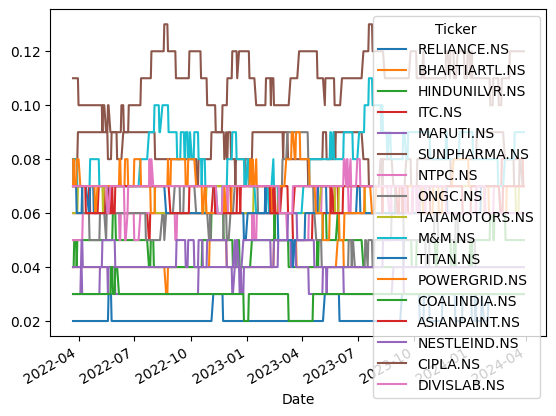

In [36]:
pd.DataFrame(test_weights, columns = data.columns, index = test_index).round(2).plot()

<Axes: xlabel='Date'>

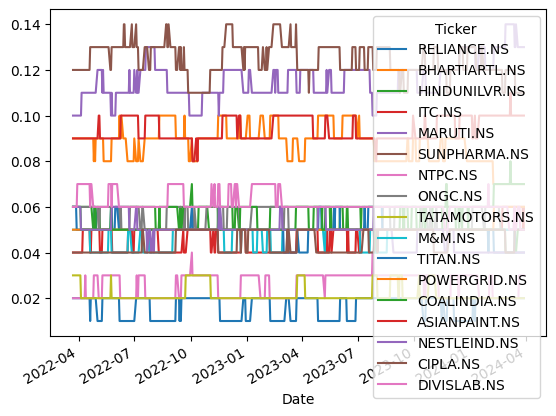

In [37]:
pd.DataFrame(test_weights1, columns = data.columns, index = test_index).round(2).plot()